In [1]:
%matplotlib notebook
import math
import json
import sys
import fileinput
import func
import re
from operator import itemgetter
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot

#joint length
l1 = 160
l2 = 200
l3 = l1 + l2

# formula settings
d_max = 50
k_z = 20
k = .01
r = 10
eps = 2
qty = 30
r_2 = 2

In [8]:
def EnergyChange(a1, a2):
    angle_a_delta = a1[0] - a2[0]
    angle_b_delta = a1[1] - a2[1]
    angle_z_delta = a1[2] - a2[2]
    return (math.pow(angle_a_delta, 2) + math.pow(angle_b_delta, 2) +
            k_z * math.pow(angle_z_delta, 2))

def CartSpace(a1, a2):
    x_delta = a1[0] - a2[0]
    y_delta = a1[1] - a2[1]
    return (math.pow(x_delta, 2) + math.pow(y_delta, 2))

def Locality(a, r, space, trajectory):
    local_pnt = []
    xy = (a[0], a[1])
    for i in range(xy[0] - r, xy[0] + r):
        for j in range(xy[1] - r, xy[1] + r):
            ang_list = data[(i,j)]
            if (ang_list):
                for ang in ang_list:
                    if (ang[2] - a[2][2] < 90):
                        local_pnt.append((i, j, tuple(ang)))
    return (local_pnt)

def getMidpointC(p1, p2):
    mid_x = (p1[0] + p2[0]) / 2
    mid_y = (p1[1] + p2[1]) / 2
    return (mid_x, mid_y)


<IPython.core.display.Javascript object>


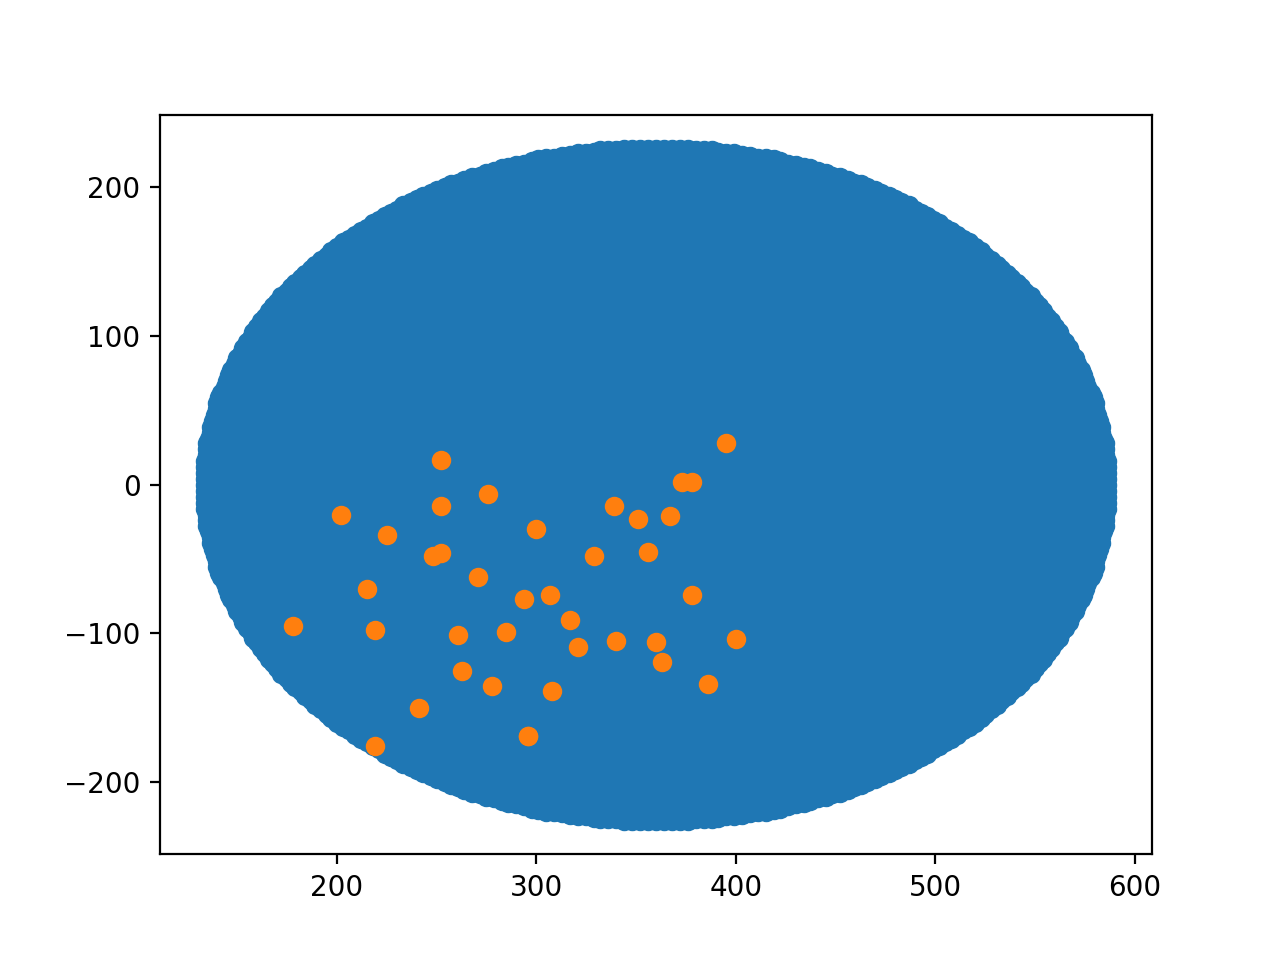

((296, -169), 0, 0)
((261, -101), 1, 1)
((178, -95), 1, 1)
((252, -46), 1, 1)
((252, 17), 1, 1)
((300, -30), 1, 1)
((378, 2), 1, 1)
((356, -45), 1, 1)
((400, -104), 1, 1)
((321, -109), 1, 1)
((296, -169), 1, 1)
((219, -176), 0, 0)
((395, 28), 1, 1)
((202, -20), 0, 0)
((386, -134), 1, 1)


In [12]:
ifile = "gcode.txt"
ofile = "output.txt"

# load json data

data_pnts = None
with open('data_pnts.json', 'r') as fp:
    data_pnts = json.load(fp)

if not data_pnts:
    print ("Unable to load data file.")
    exit()

if data_pnts:
    data  = defaultdict(list)
    for i in data_pnts:
        for j in i["value"]:
            data[tuple(i["key"])].append(j)
            
points = []
for i in data:
    points.append(i)
x_p, y_p = zip(*points)

circ_fig = plt.figure()
circ_fig.canvas.set_window_title('Points from Data')
ax1 = circ_fig.add_subplot(111)
ax1.scatter(x_p, y_p)

def parseCommand(line, input_list):
    res = re.search("[gG]([0-9]+)", line)
    if (res):
        g = int(res.group(1))
    else:
        g = -1
    res = re.search("[xX](-?[0-9]+)", line)
    if (res):
        x = int(res.group(1))
    else:
        x = input_list[-1][1][0]
    res = re.search("[yY](-?[0-9]+)", line)
    if (res):
        y = int(res.group(1))
    else:
        y = input_list[-1][1][1]
    res = re.search("[pP]([0-9]+)", line)
    if (res):
        p = int(res.group(1))
    else:
        p = input_list[-1][2]
    return (g, x, y, p)

p1 = func.getPosition((-90, 90), l1, l2)
p0 = func.getPosition((0, 0), l1, l2)
radius = func.getDist(p0, p1)

# load (x,y) points
input_pnts = []
with open(ifile, 'r') as fInput:
    cnt = 1
    for line in fInput:
        cnt += 1
        res = parseCommand(line, input_pnts)
        g, x, y, p = res
        if (g >= 0):
            calc_r = math.sqrt(math.pow(x, 2) + math.pow(y, 2))
            if (calc_r <= radius):
                x = x + l3
                input_pnts.append(((int(x), int(y)), int(p), int(g)))
            else:
                print ("Command #" + str(cnt) + " Out of bounds :" + line + "Accessible Plate Radius = " + str(radius) + ". User Radius = " + str(calc_r))
        else:
            print ("Command #" + str(cnt) + ": Error!" + line)
            

if not input_pnts:
    print ("Unable to load input file.")
    #quit()

for i in input_pnts:
    print (i)

x, y = func.getPosition((0, 0), l1, l2)
start_pnt = (int(x), int(y), (0, 0, 0), 0)
pnt_set = []

if (input_pnts):
    test_pnt = data[input_pnts[0][0]]
    if (not test_pnt):
        found = False
        x_1 = input_pnts[0][0][0]
        y_1 = input_pnts[0][0][1]
        for i in range(x_1 - r_2, x_1 + r_2):
            if (not found):
                for j in range(y_1 - r_2, y_1 + r_2):
                    if (data[(i, j)]) and (not found):
                        found = True
                        test_pnt = data[(i, j)]
                        break
                    else:
                        break
            else:
                break
    first_pnt = min(test_pnt, key=lambda ob: EnergyChange(start_pnt[2], ob))
    #print(test_res)

    x, y = input_pnts[0][0]
    p = input_pnts[0][1]
    pnt_set.append((x, y, first_pnt, p))

    def getTrajectory(start, cartlist):
        ret_list = []
        if not cartlist:
            return ([])
        x, y = start[0], start[1]
        x_1, y_1 = cartlist[0][0]
        x_1 = int(x_1)
        y_1 = int(y_1)
        if (func.getDist((x,y), (x_1, y_1)) > d_max) and (cartlist[0][2]):
            new_cartlist = [tuple((getMidpointC((x,y), (x_1, y_1)), cartlist[0][1], cartlist[0][2]))] + cartlist
            return getTrajectory(start, new_cartlist)
            #return getTrajectory(start, cartlist.insert(0, getMidpointC((x,y), (x_1, y_1))))
        ang = data[(x_1, y_1)]
        ang_res = None
        if not ang:
            min_list = []
            for i in range(x_1 - r_2, x_1 + r_2):
                for j in range(y_1 - r_2, y_1 + r_2):
                    if (data[(i, j)]):
                        tmp = min(data[(i,j)], key=lambda ob: EnergyChange(start[2], ob))
                        min_list.append((i, j, tuple(tmp), start[3]))
            if not min_list:
                print ("nothing")
            ang_res = min(min_list, key=lambda ob: EnergyChange(start[2], ob[2]))
        else:
            tmp = min(ang, key=lambda ob: EnergyChange(start[2], ob))
            ang_res = (x_1, y_1, tuple(tmp))
        if (3600 - abs(tmp[2]) <= 360):
            print ("Too many rotations")
            exit()
        ret_list.append((x_1, y_1, ang_res[2], cartlist[0][1]))
        return (ret_list + getTrajectory(ret_list[-1], cartlist[1:]))

    pnt_set  = pnt_set + getTrajectory(pnt_set[-1], input_pnts[1:])

    x_p, y_p, ang, p_val = zip(*pnt_set)
    ax1.scatter(x_p, y_p)



<IPython.core.display.Javascript object>


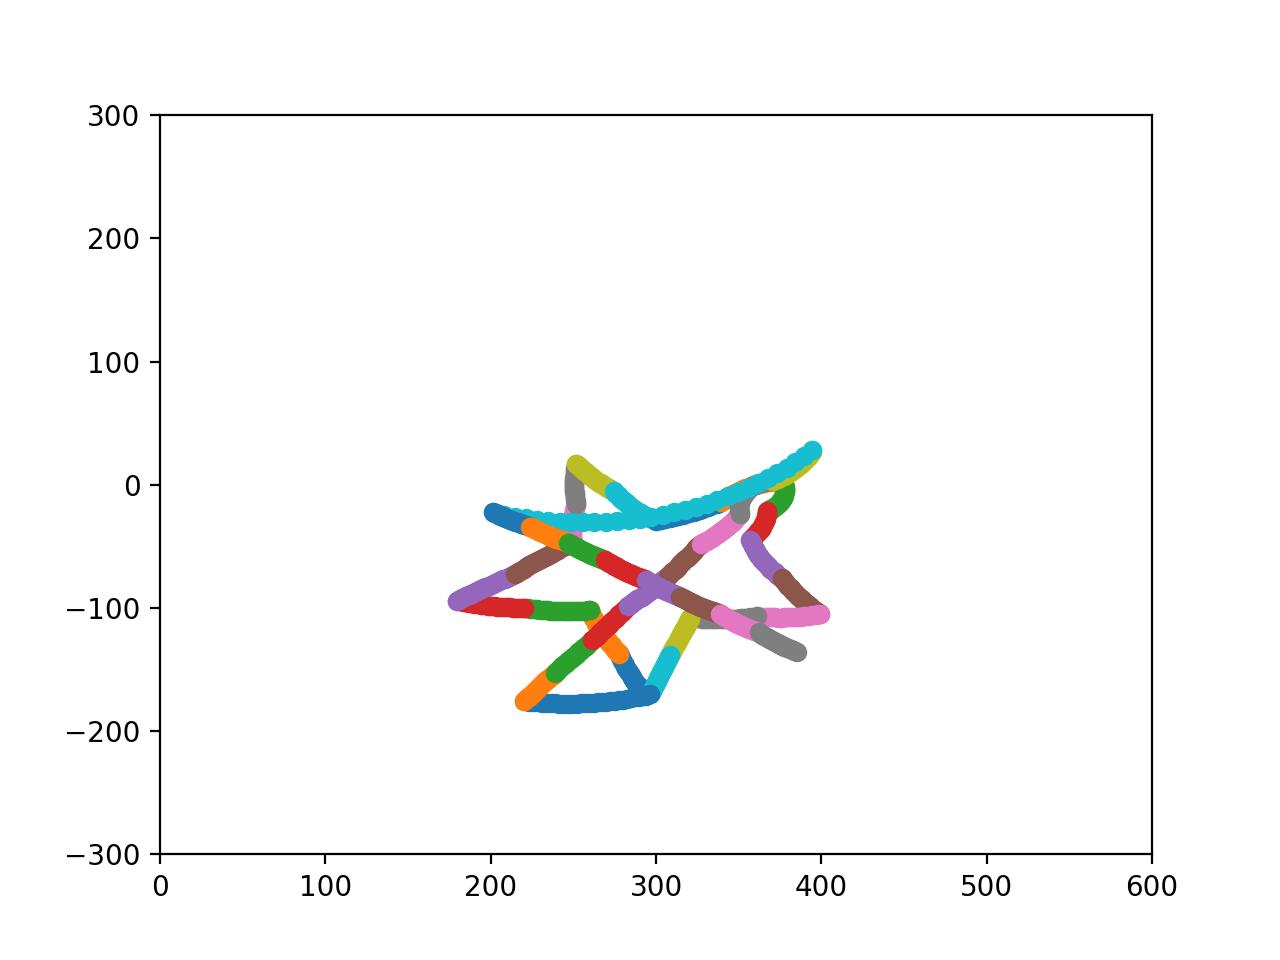

(-300, 300)

In [13]:
motion_fig = plt.figure()
motion_fig.canvas.set_window_title('Motion')
ax3 = motion_fig.add_subplot(111)
x_p, y_p = zip(*points)
#ax3.scatter(x_p, y_p)

def calc(l_1, l_2, x, y, z):
    x_s, y_s = func.getPosition((x, y), l_1, l_2)
    res_x, res_y = func.getTransform((x_s, y_s), (l_1 + l_2, 0), z)
    return (res_x, res_y)

def getInter(p1, p2):
    x_ret, y_ret = [], []
    
    x_1, y_1, z_1 = p1
    x_2, y_2, z_2 = p2
    
    xt_inc = -(x_1 - x_2) / float(qty)
    yt_inc = -(y_1 - y_2) / float(qty)
    zt_inc = -(z_1 - z_2) / float(qty)
    for i in range(qty + 1):
        x, y = calc(l1, l2, x_1 + xt_inc * i, y_1 + yt_inc * i, z_1 + zt_inc * i)
        x_ret.append(x)
        y_ret.append(y)
    return (x_ret, y_ret)
        
x_p, y_p = [], []
for i in range(len(pnt_set) - 1):
    if (i < len(pnt_set)):
        A = pnt_set[i]
        B = pnt_set[i + 1]
        x, y = getInter(A[2], B[2])
        ax3.scatter(x, y)
ax3.set_xlim(xmin=0, xmax=600)
ax3.set_ylim(ymin=-300, ymax=300)


In [5]:
with open(ofile, 'w') as fOutput:
    for i in pnt_set:
        x = i[2][1] + i[2][0]
        y = i[2][0]
        z = i[2][2]
        p = i[3]
        fOutput.write("G0 X%d Y%d Z%d P%d\n" % (x, y, z, p))